In [1]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict as dd
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
folderpath = '../../Images/Merged_Categories'

In [4]:
file_dict = dd(list)
# map each category to a list of imgnames in that category
for file in os.listdir(folderpath):
    filepath = os.path.join(folderpath, file)
    if os.path.isdir(filepath):
        for imgname in os.listdir(filepath):
            file_dict[file].append(imgname)

In [78]:
for category in file_dict.keys():
        print(category)

Cardboard
Glass
Metal
Paper
Plastic
Trash


In [135]:
train_files = []
weights = []
y_train = []
i = 0
for category in file_dict.keys():
    for file in os.listdir(os.path.join(folderpath, category)):
        # append file name
        train_files.append(file)
        # get weight value (not used yet)
        weight_str = file[file.find('--')+2:-4]
        if '_' in weight_str:
            weight = float(weight_str[0:weight_str.find('_')])+float(weight_str[weight_str.find('_')+1:]) / 10
        else:
            weight = float(weight_str)
#         print(weight_str, weight)
        weights.append(weight)
        # get one-hot encoded cateegory
        encoded_y = np.zeros(len(file_dict.keys()))
        encoded_y[i] += 1
        y_train.append(encoded_y)
    i += 1
y_train = np.array(y_train)

In [136]:
print("Files in train_files: %d" % len(train_files))

Files in train_files: 458


In [226]:
target_width = 224
target_height = 224
channels = 3
num_classes = len(file_dict.keys())

dataset = np.ndarray(shape=(len(train_files), 
                            target_height, target_width, channels),
                     dtype=np.float32)

labels_in_order = [i for i in file_dict.keys()] # for matching one-hot encoded labels to category names
i = 0
for file in train_files:
#     print(np.where(y_train[i]==1.)[0][0])
    img = load_img(folderpath + '/' + labels_in_order[np.where(y_train[i]==1.)[0][0]] + '/' + file)
    img.thumbnail((target_width, target_height))
    x = img_to_array(img)
#     print(x[0])
    x.reshape((3, 224, 224))
#     x = (x-128.0) / 128.0
    dataset[i] = x
    i += 1

In [227]:
dataset.shape

(458, 224, 224, 3)

In [3]:
from sklearn.model_selection import train_test_split

In [250]:
Xtrain, Xtest, ytrain, ytest = train_test_split(dataset, y_train, 
                                                test_size=0.2)
print("Train set size: {0}".format(len(Xtrain)))
for category in file_dict.keys():
    print("   num in {0}: {1}".format(category, len([i for i in ytrain if list(file_dict.keys()).index(category)==np.where(i==1.)[0][0]]))) 
print("Test set size: {0}".format(len(Xtest)))
for category in file_dict.keys():
    print("   num in {0}: {1}".format(category, len([i for i in ytest if list(file_dict.keys()).index(category)==np.where(i==1.)[0][0]])))

Train set size: 366
   num in Cardboard: 86
   num in Glass: 50
   num in Metal: 50
   num in Paper: 35
   num in Plastic: 55
   num in Trash: 90
Test set size: 92
   num in Cardboard: 19
   num in Glass: 21
   num in Metal: 16
   num in Paper: 12
   num in Plastic: 10
   num in Trash: 14


In [251]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    fill_mode='nearest',
    validation_split = 0.2
    )

datagen.fit(Xtrain)

train_generator = datagen.flow(Xtrain, ytrain, subset='training')
validation_generator = datagen.flow(Xtrain, ytrain, subset='validation')

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping

In [253]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 6)


In [254]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(file_dict.keys()), activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_11 (KerasLayer)  (None, 1280)              2257984   
_________________________________________________________________
dense_19 (Dense)             (None, 500)               640500    
_________________________________________________________________
dropout_11 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 3006      
Total params: 2,901,490
Trainable params: 643,506
Non-trainable params: 2,257,984
_________________________________________________________________


In [255]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [256]:
hist = model.fit(train_generator, 
                 epochs=50,
                 verbose=1,
                 steps_per_epoch=len(train_generator),
                 validation_data=validation_generator,
                 validation_steps=len(validation_generator),
                 callbacks=[EarlyStopping(monitor='val_loss',
                                          mode='min',
                                          verbose=1,
                                          patience=10,
                                          restore_best_weights=True)]).history

Epoch 1/50
10/10 [==============================] - 6s 626ms/step - loss: 2.1894 - acc: 0.2799 - val_loss: 1.4694 - val_acc: 0.3699
Epoch 2/50
10/10 [==============================] - 6s 566ms/step - loss: 1.2168 - acc: 0.5222 - val_loss: 1.3333 - val_acc: 0.5068
Epoch 3/50
10/10 [==============================] - 5s 523ms/step - loss: 0.8345 - acc: 0.6689 - val_loss: 1.1109 - val_acc: 0.5890
Epoch 4/50
10/10 [==============================] - 5s 540ms/step - loss: 0.6956 - acc: 0.7338 - val_loss: 1.0968 - val_acc: 0.5342
Epoch 5/50
10/10 [==============================] - 5s 543ms/step - loss: 0.6179 - acc: 0.7816 - val_loss: 1.0454 - val_acc: 0.6575
Epoch 6/50
10/10 [==============================] - 5s 542ms/step - loss: 0.5389 - acc: 0.7952 - val_loss: 0.9572 - val_acc: 0.6712
Epoch 7/50
10/10 [==============================] - 5s 537ms/step - loss: 0.4543 - acc: 0.8567 - val_loss: 0.9896 - val_acc: 0.5890
Epoch 8/50
10/10 [==============================] - 5s 532ms/step - loss: 0.

In [315]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(validation_generator)

3/3 [==============================] - 1s 203ms/step - loss: 0.8525 - acc: 0.7397


In [316]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.85
Final accuracy: 73.97%


In [5]:
import matplotlib.pyplot as plt

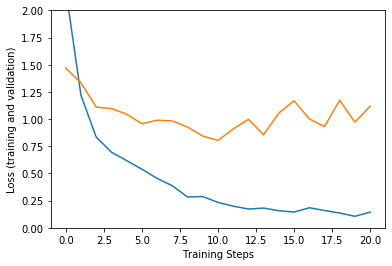

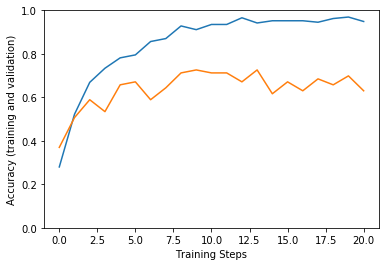

In [318]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [7]:
RACOON_SAVED_MODEL = "saved_models/racoon"
tf.saved_model.save(model, RACOON_SAVED_MODEL)

In [8]:
# Load SavedModel

racoon_model = hub.load(RACOON_SAVED_MODEL)
print(racoon_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x0000023A9506C548>


In [9]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(validation_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

NameError: name 'validation_generator' is not defined

In [322]:
tf_model_predictions = racoon_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 6)


In [323]:
dataset_labels = np.asarray(list(file_dict.keys()))
print(dataset_labels)

['Cardboard' 'Glass' 'Metal' 'Paper' 'Plastic' 'Trash']


In [324]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Cardboard,Glass,Metal,Paper,Plastic,Trash
0,0.653267,0.014348,0.254181,0.045151,0.002639,0.030413
1,0.577477,0.030161,0.002447,0.245352,0.005278,0.139285
2,0.183194,0.021265,0.003300,0.006405,0.000303,0.785534
3,0.798324,0.000777,0.000308,0.147426,0.000193,0.052972
4,0.000107,0.713124,0.003868,0.000061,0.282387,0.000454


In [325]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

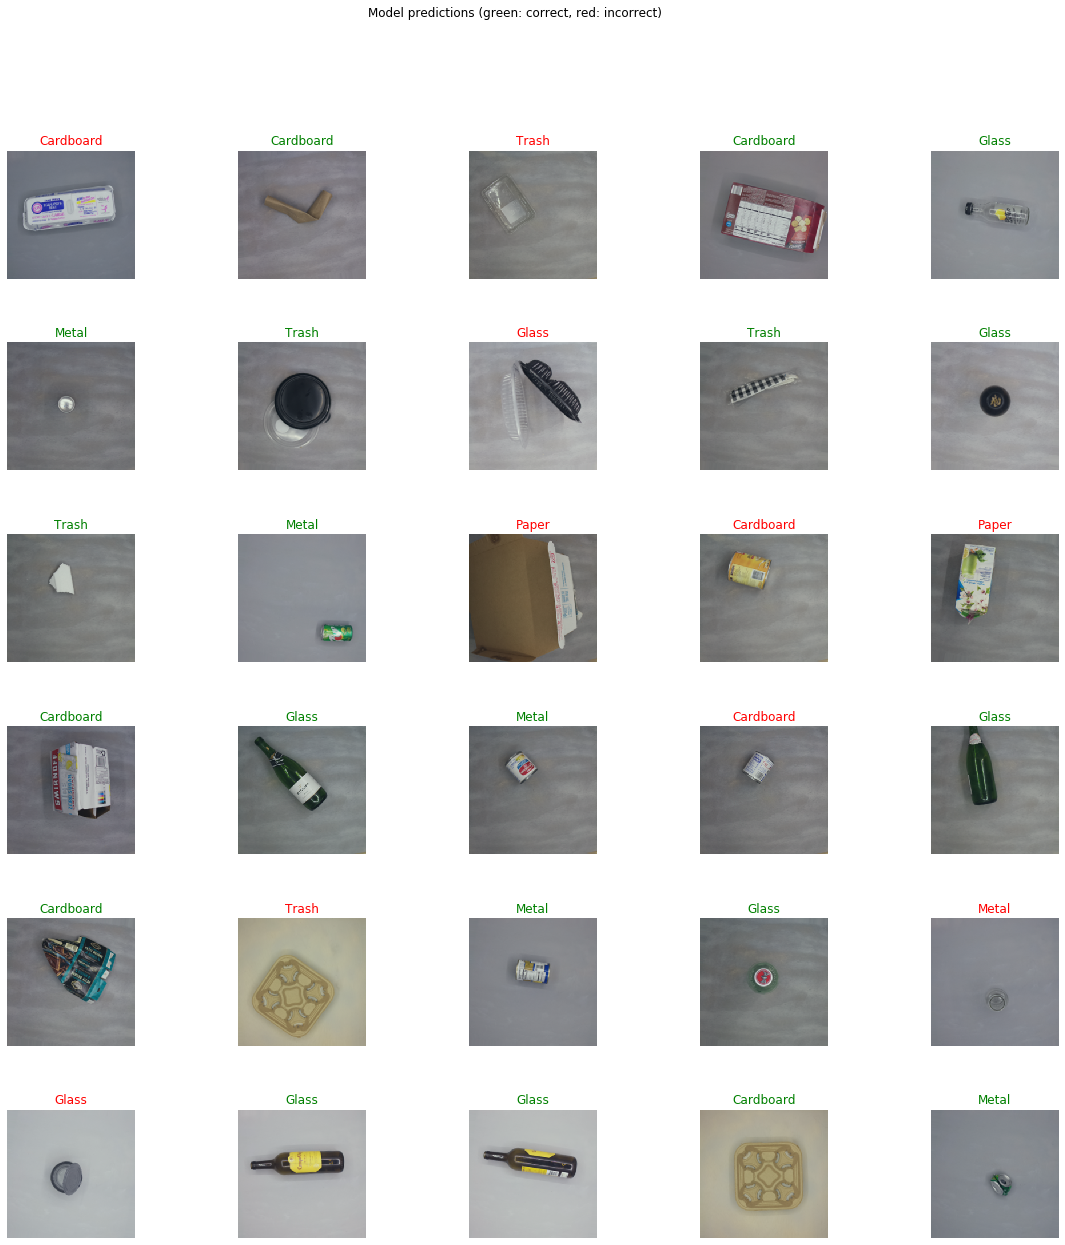

In [326]:
# Print images batch and labels predictions

plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow((val_image_batch[n]*0.1 + 0.5))
    color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
    plt.title(predicted_labels[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")